# Wikipedia Talk Data - Getting Started

## This file contains the experiments performed and the accuracy of each. The best performing ones were selected and used in the a different file for submission purposes. 

### - Surya Roshan M

This notebook gives an introduction to working with the various data sets in [Wikipedia
Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Please refer to our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each data set and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology. 

In this notebook we show how to build a simple classifier for detecting personal attacks and apply the classifier to a random sample of the comment corpus to see whether discussions on user pages have more personal attacks than discussion on article pages.

##  Building a classifier for personal attacks
In this section we will train a simple bag-of-words classifier for personal attacks using the [Wikipedia Talk Labels: Personal Attacks]() data set.

In [1]:
import pandas as pd
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix
#"import pandas_profiling as pp


In [2]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

# You can edit the code here to download only once, and not download it later                
#download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
#download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

Use display instead of Print to print prettily 

In [3]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [4]:
display(comments.head(100))


,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train
...,...,...,...,...,...,...
1185345,NEWLINE_TOKENNEWLINE_TOKEN::Thanks. While I'm ...,2003,True,article,random,test
1212997,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENNEWLINE...,2003,True,user,random,dev
1220372,NEWLINE_TOKENNEWLINE_TOKENWikipedia is banned?...,2003,True,article,random,test


In [5]:
#display(annotations.head(100))

In [6]:
len(annotations['rev_id'].unique())

115864

In [7]:
# labels a comment as an atack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5
#print(labels)

In [8]:
# join labels and comments
comments['attack'] = labels
display(comments.head())
comments.to_csv("raw_comments.csv")

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,False
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train,False
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False
93890,This page will need disambiguation.,2002,True,article,random,train,False


In [3]:
comments.info()

NameError: name 'comments' is not defined

# Preprocessing

In [9]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))


In [10]:
comments['comment']=comments['comment'].apply(lambda x: x.replace("`"," "))
comments['comment']=comments['comment'].apply(lambda x: x.replace("."," "))
#comments['comment']=comments['comment'].apply(lambda x: x.lower())
import re
comments['comment']=comments['comment'].apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', ' ', x))
comments['comment']=comments['comment'].apply(lambda s : re.sub(r'[^\w\s]','',s))
comments['comment']=comments['comment'].apply(lambda x:  re.sub("\S*\d\S*", "", x).strip())

comments['comment']=comments['comment'].apply(lambda x: re.sub(r'\s+'," ",x))



This contains the full data which can be used for training or other purposes

In [11]:
display(comments.head(100))

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,This is not creative Those are the dictionary ...,2002,False,article,random,train,False
44816,the term standard model is itself less NPOV th...,2002,False,article,random,train,False
49851,True or false the situation as of March was su...,2002,False,article,random,train,False
89320,Next maybe you could work on being less condes...,2002,True,article,random,dev,False
93890,This page will need disambiguation,2002,True,article,random,train,False
...,...,...,...,...,...,...,...
1185345,Thanks While Im attemtping without any trainin...,2003,True,article,random,test,False
1212997,Hi Sannse I answered you question on the talkW...,2003,True,user,random,dev,False
1220372,Wikipedia is banned Why,2003,True,article,random,test,False


In [12]:
comments.dtypes

comment      object
year          int64
logged_in      bool
ns           object
sample       object
split        object
attack         bool
dtype: object

# data analysis 

In [74]:
comments.to_csv("comments.csv")

In [44]:
x=y=None
data=comments
display(comments)
encode=['ns','sample','year']
x=data.iloc[:,1:-1]
y=data.iloc[:,-1]

for enc in encode:
    x[enc]=x[enc].astype('category')
    x=x.join(pd.get_dummies(x[enc]))
data=x.join(y)
display(data)
data = data.drop(columns=['comment','split'])
data

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,this is not creative those are the dictionary ...,2002,False,0,1,train,False
44816,the term standard model is itself less npov th...,2002,False,0,1,train,False
49851,true or false the situation as of march was su...,2002,False,0,1,train,False
89320,next maybe you could work on being less condes...,2002,True,0,1,dev,False
93890,this page will need disambiguation,2002,True,0,1,train,False
...,...,...,...,...,...,...,...
699848324,these sources dont exactly exude a sense of im...,2016,True,0,0,train,False
699851288,the institute for historical review is a peerr...,2016,True,0,0,test,False
699857133,the way youre trying to describe it in this ar...,2016,True,0,0,train,False


ValueError: columns overlap but no suffix specified: Index([0, 1], dtype='object')

In [37]:
from sklearn.preprocessing import LabelEncoder
data=comments
encode=['ns','sample']
for x in encode:
    data[x]=LabelEncoder().fit_transform(data[x])
display(data)


,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,this is not creative those are the dictionary ...,2002,False,0,1,train,False
44816,the term standard model is itself less npov th...,2002,False,0,1,train,False
49851,true or false the situation as of march was su...,2002,False,0,1,train,False
89320,next maybe you could work on being less condes...,2002,True,0,1,dev,False
93890,this page will need disambiguation,2002,True,0,1,train,False
...,...,...,...,...,...,...,...
699848324,these sources dont exactly exude a sense of im...,2016,True,0,0,train,False
699851288,the institute for historical review is a peerr...,2016,True,0,0,test,False
699857133,the way youre trying to describe it in this ar...,2016,True,0,0,train,False


In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#data = comments
#data=data.astype(str)

X = data.iloc[:,1:-1]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

ValueError: could not convert string to float: 'train'

In [128]:

X = data.iloc[:,1:-1]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
X=X.astype(str)
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

ValueError: could not convert string to float: 'False'

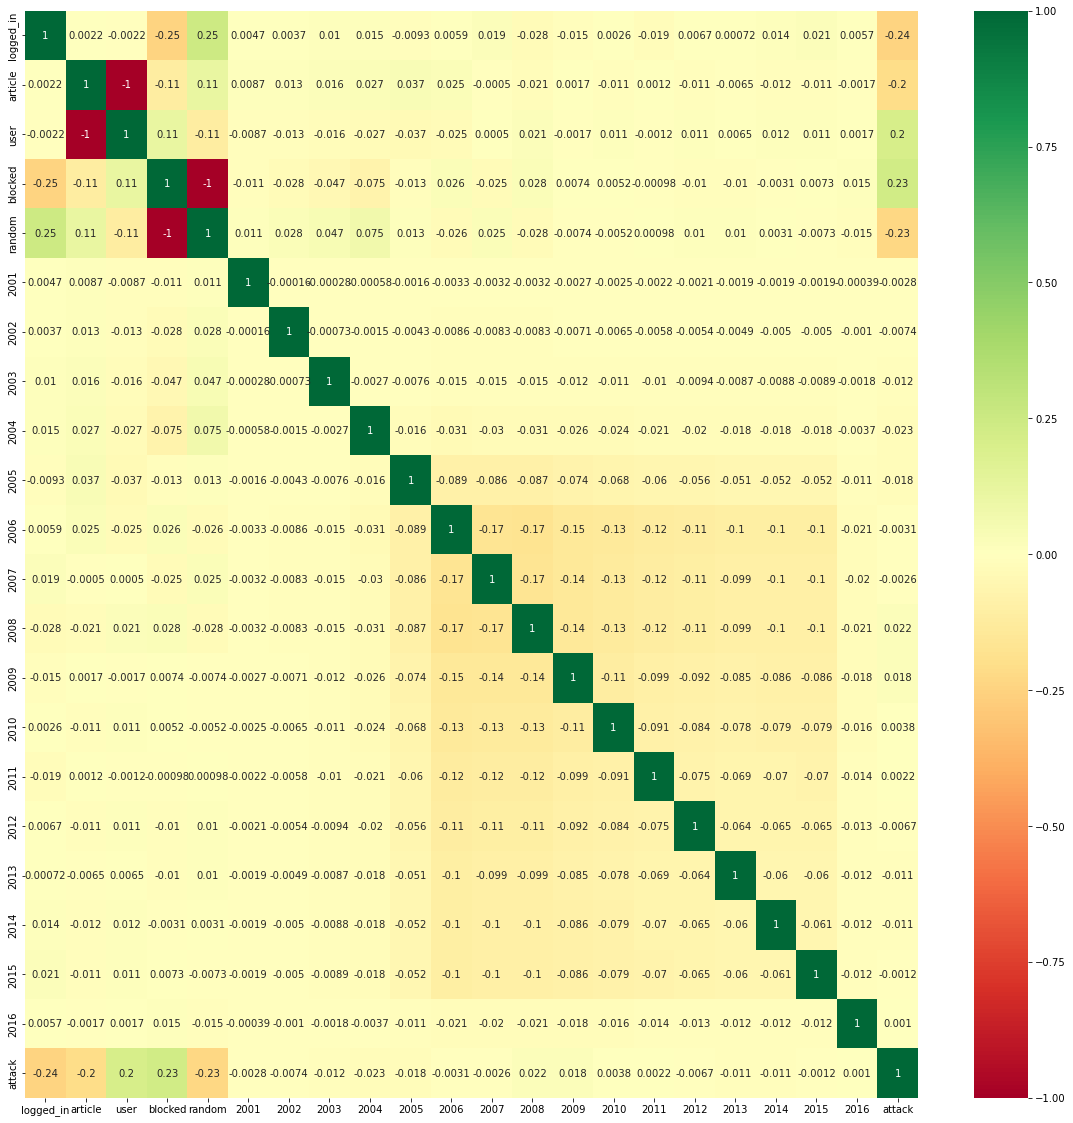

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

#data= comments

X = data.iloc[:,:-1]  #independent columns

y = data.iloc[:,-1]    #target column i.e price range

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")


In [131]:
data['ns'].corr(data['attack'])

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [120]:
#k Cross validation
print(train_comments['comment'])
train_comments=comments[['split']].query('train')
train_comments=comments['split'].query('test')
display(train_comments)

rev_id
37675        this is not creative those are the dictionary ...
44816        the term standard model is itself less npov th...
49851        true or false the situation as of march was su...
93890                       this page will need disambiguation
102817       important note for all sysops there is a bug i...
                                   ...                        
699756185    the lead itself is original research where is ...
699813325    im talking about you making unjustified major ...
699848324    these sources dont exactly exude a sense of im...
699857133    the way youre trying to describe it in this ar...
699897151    alternate option is there perhaps enough newsw...
Name: comment, Length: 69526, dtype: object


UndefinedVariableError: name 'train' is not defined

# Training the classifier

In [31]:
'''comments_nospace=train_comments['comment'].apply(lambda x:x.replace(" ",""))
vectorizer=TfidfVectorizer(max_features=10000,ngram_range=(2,2),analyzer='char')
train_comments_vectorized=vectorizer.fit_transform(comments_nospace)'''

'comments_nospace=train_comments[\'comment\'].apply(lambda x:x.replace(" ",""))\nvectorizer=TfidfVectorizer(max_features=10000,ngram_range=(2,2),analyzer=\'char\')\ntrain_comments_vectorized=vectorizer.fit_transform(comments_nospace)'

## Decision tree 

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# fit classifer
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    #('vect', CountVectorizer(max_features = 10000)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', DecisionTreeClassifier(random_state = 123)),
    #('clf',LogisticRegression(random_state=0)),
    #('clf',MultinomialNB()),
    #('clf',RandomForestClassifier()),
    #('clf',LinearSVC())
])
#clf=Pipeline([('vec',vectorizer),('clf',DecisionTreeClassifier(random_state=123))])
clf = clf.fit(train_comments['comment'], train_comments['attack'])

y_predict=clf.predict(test_comments['comment'])
#print(y_predict)
#print(test_comments['attack'])
met = metrics.classification_report(test_comments['attack'], y_predict)
print(met)
from sklearn.metrics import confusion_matrix

display(confusion_matrix(test_comments['attack'],y_predict))

              precision    recall  f1-score   support

       False       0.95      0.95      0.95     20422
        True       0.64      0.62      0.63      2756

    accuracy                           0.91     23178
   macro avg       0.79      0.79      0.79     23178
weighted avg       0.91      0.91      0.91     23178



array([[19464,   958],
       [ 1055,  1701]], dtype=int64)

## Logistic Regression

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline
# fit classifer
#clf = Pipeline([
clf=make_pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    #('vect', CountVectorizer(max_features = 10000)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    #('clf', DecisionTreeClassifier(random_state = 123)),
    
    ('clf',LogisticRegression(random_state=0,class_weight={False:1.1, True:8.8})),
    #('clf',MultinomialNB()),
    #('clf',RandomForestClassifier()),
    ##('clf',LinearSVC())
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])

y_predict=clf.predict(test_comments['comment'])
#print(y_predict)
#print(test_comments['attack'])
met = metrics.classification_report(test_comments['attack'], y_predict)
print(met)
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_comments['attack'],y_predict,labels=[False,True]))

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '[('vect', CountVectorizer(max_features=10000, ngram_range=(1, 2))), ('tfidf', TfidfTransformer()), ('smote', SMOTE(random_state=12)), ('clf', LogisticRegression(class_weight={False: 1.1, True: 8.8}, random_state=0))]' (type <class 'list'>) doesn't

## MultinomialNB

In [113]:


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2),analyzer='word')),
    #('vect', CountVectorizer(max_features = 10000)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    #('clf', DecisionTreeClassifier(random_state = 123)),
    #('clf',LogisticRegression(random_state=0)),
    ('clf',MultinomialNB()),
    #('clf',RandomForestClassifier()),
    #('clf',LinearSVC())
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])

y_predict=clf.predict(test_comments['comment'])
#print(y_predict)
#print(test_comments['attack'])
met = metrics.classification_report(test_comments['attack'], y_predict)
print(met)
from sklearn.metrics import confusion_matrix

display(confusion_matrix(test_comments['attack'],y_predict))

              precision    recall  f1-score   support

       False       0.94      0.99      0.96     20422
        True       0.89      0.51      0.65      2756

    accuracy                           0.93     23178
   macro avg       0.92      0.75      0.81     23178
weighted avg       0.93      0.93      0.93     23178



array([[20257,   165],
       [ 1353,  1403]], dtype=int64)

## Random Forest  

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# fit classifer
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    #('vect', CountVectorizer(max_features = 10000)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    #('clf', DecisionTreeClassifier(random_state = 123)),
    #('clf',LogisticRegression(random_state=0)),
    #('clf',MultinomialNB()),
    ('clf',RandomForestClassifier()),
    #('clf',LinearSVC())
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])

y_predict=clf.predict(test_comments['comment'])
#print(y_predict)
#print(test_comments['attack'])
met = metrics.classification_report(test_comments['attack'], y_predict)
print(met)
from sklearn.metrics import confusion_matrix

display(confusion_matrix(test_comments['attack'],y_predict))

              precision    recall  f1-score   support

       False       0.94      0.99      0.97     20422
        True       0.91      0.52      0.67      2756

    accuracy                           0.94     23178
   macro avg       0.93      0.76      0.82     23178
weighted avg       0.94      0.94      0.93     23178



array([[20286,   136],
       [ 1313,  1443]], dtype=int64)

## Linear SVC

In [115]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# fit classifer
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    #('vect', CountVectorizer(max_features = 10000)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    #('clf', DecisionTreeClassifier(random_state = 123)),
    #('clf',LogisticRegression(random_state=0)),
    #('clf',MultinomialNB()),
    #('clf',RandomForestClassifier()),
    ('clf',LinearSVC())
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])

y_predict=clf.predict(test_comments['comment'])
#print(y_predict)
#print(test_comments['attack'])
met = metrics.classification_report(test_comments['attack'], y_predict)
print(met)
from sklearn.metrics import confusion_matrix

display(confusion_matrix(test_comments['attack'],y_predict))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     20422
        True       0.86      0.64      0.73      2756

    accuracy                           0.94     23178
   macro avg       0.91      0.81      0.85     23178
weighted avg       0.94      0.94      0.94     23178



array([[20146,   276],
       [ 1004,  1752]], dtype=int64)

## Multi layered classifier 

In [116]:
 from sklearn.neural_network import MLPClassifier

# fit classifer
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    #('vect', CountVectorizer(max_features = 10000)),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    #('clf', DecisionTreeClassifier(random_state = 123)),
    #('clf',LogisticRegression(random_state=0)),
    #('clf',MultinomialNB()),
    #('clf',RandomForestClassifier()),
    #('clf',LinearSVC()),
    ('clf',MLPClassifier())
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])

y_predict=clf.predict(test_comments['comment'])
#print(y_predict)
#print(test_comments['attack'])
met = metrics.classification_report(test_comments['attack'], y_predict)
print(met)


display(confusion_matrix(test_comments['attack'],y_predict))

              precision    recall  f1-score   support

       False       0.95      0.97      0.96     20422
        True       0.73      0.64      0.68      2756

    accuracy                           0.93     23178
   macro avg       0.84      0.80      0.82     23178
weighted avg       0.93      0.93      0.93     23178



array([[19785,   637],
       [  997,  1759]], dtype=int64)

# k Cross validation 

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [107]:
def kCrossValidation(clf,comments):
    kf=KFold(n_splits=10)
    oversample = RandomOverSampler(sampling_strategy='minority')
    undersample= RandomUnderSampler()
    #clf=classifier
    X=comments['comment']
    
    display(type(X))
    y=comments['attack']
    print(type(y))
    score_array =[]
    confusion_matrix_array=[]
        
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        #print(X_train.shape)
        #print(y_train.shape)
        #X_train_upsample, y_train_upsample = oversample.fit_resample(X_train.to_frame(name='comment'),y_train)
        #X_train_upsample, y_train_upsample = undersample.fit_resample(X_train.to_frame(name='comment'),y_train)
        #print(X_train_upsample.value_counts())
        #print(y_train_upsample.value_counts())
        #trained_clf=clf.fit(X_train_upsample['comment'],y_train_upsample)
        
        #below is for imbalanced
        print(y_train.value_counts())
        trained_clf=clf.fit(X_train,y_train)
        
        
        y_pred = trained_clf.predict(X_test)
        score_array.append(metrics.classification_report(y_test, y_pred,output_dict=True))
        confusion_matrix_array.append(confusion_matrix(y_test,y_pred))
        
    return score_array,confusion_matrix_array
    

In [28]:
from collections import defaultdict
def getAverage(score,type_Avg):
    avgs=defaultdict(lambda: list())

    #print(score)
    for report in score:
        display(pd.DataFrame(report).transpose())
        #print(report['macro avg'].keys())
        for key in report[type_Avg].keys():

            avgs[key].append(report[type_Avg][key])
    #print(avgs)
    for key in avgs.keys():
        print("average",key,"=",sum(avgs[key])/len(avgs[key]))

In [29]:
def getAccuracyAverage(score):
    avgs=[]
    for report in score:
        avgs.append(report['accuracy'])
    
    print(sum(avgs)/len(avgs))
    

In [15]:
def resample(data):
    x=data.iloc[:,0:1]
    y=data.iloc[:,-1]
    display(x)
    display(y)
    oversample = RandomOverSampler(sampling_strategy='minority')
    x_over, y_over = oversample.fit_resample(x, y)
    print(x_over,y_over)
    return x_over,y_over

## Decision tree 

In [199]:
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', DecisionTreeClassifier(random_state = 123)),
])
#cross_score_val(clf,comments['comment'],comments['attack'])
#print(cross_score_val)

score,confusion=kCrossValidation(clf,comments)


<class 'pandas.core.series.Series'>
False    91739
True     12538
Name: attack, dtype: int64
False    92089
True     12188
Name: attack, dtype: int64
False    92038
True     12239
Name: attack, dtype: int64
False    92126
True     12151
Name: attack, dtype: int64
False    92274
True     12004
Name: attack, dtype: int64
False    92238
True     12040
Name: attack, dtype: int64
False    92046
True     12232
Name: attack, dtype: int64
False    92032
True     12246
Name: attack, dtype: int64
False    91893
True     12385
Name: attack, dtype: int64
False    91991
True     12287
Name: attack, dtype: int64


In [200]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
print(confusion)

,precision,recall,f1-score,support
False,0.957601,0.951875,0.954729,10535.000000
True,0.545291,0.577947,0.561144,1052.000000
accuracy,0.917925,0.917925,0.917925,0.917925
macro avg,0.751446,0.764911,0.757937,11587.000000
weighted avg,0.920167,0.917925,0.918995,11587.000000


,precision,recall,f1-score,support
False,0.944091,0.948355,0.946219,10185.000000
True,0.612094,0.592011,0.601885,1402.000000
accuracy,0.905239,0.905239,0.905239,0.905239
macro avg,0.778093,0.770183,0.774052,11587.000000
weighted avg,0.903921,0.905239,0.904555,11587.000000


,precision,recall,f1-score,support
False,0.954118,0.950762,0.952437,10236.000000
True,0.636626,0.653590,0.644996,1351.000000
accuracy,0.916113,0.916113,0.916113,0.916113
macro avg,0.795372,0.802176,0.798717,11587.000000
weighted avg,0.917099,0.916113,0.916590,11587.000000


,precision,recall,f1-score,support
False,0.947405,0.947872,0.947638,10148.000000
True,0.631102,0.628909,0.630003,1439.000000
accuracy,0.908259,0.908259,0.908259,0.908259
macro avg,0.789253,0.788390,0.788821,11587.000000
weighted avg,0.908123,0.908259,0.908191,11587.000000


,precision,recall,f1-score,support
False,0.943916,0.952600,0.948238,10000.000000
True,0.682731,0.643127,0.662338,1586.000000
accuracy,0.910236,0.910236,0.910236,0.910236
macro avg,0.813323,0.797864,0.805288,11586.000000
weighted avg,0.908163,0.910236,0.909101,11586.000000


,precision,recall,f1-score,support
False,0.943051,0.955361,0.949166,10036.000000
True,0.684285,0.626452,0.654092,1550.000000
accuracy,0.911359,0.911359,0.911359,0.911359
macro avg,0.813668,0.790906,0.801629,11586.000000
weighted avg,0.908433,0.911359,0.909690,11586.000000


,precision,recall,f1-score,support
False,0.949280,0.947888,0.948584,10228.000000
True,0.611799,0.618557,0.615159,1358.000000
accuracy,0.909287,0.909287,0.909287,0.909287
macro avg,0.780540,0.783222,0.781872,11586.000000
weighted avg,0.909724,0.909287,0.909503,11586.000000


,precision,recall,f1-score,support
False,0.952460,0.954599,0.953528,10242.000000
True,0.647994,0.636905,0.642402,1344.000000
accuracy,0.917746,0.917746,0.917746,0.917746
macro avg,0.800227,0.795752,0.797965,11586.000000
weighted avg,0.917141,0.917746,0.917437,11586.000000


,precision,recall,f1-score,support
False,0.955313,0.953473,0.954392,10381.00000
True,0.605714,0.615768,0.610700,1205.00000
accuracy,0.918350,0.918350,0.918350,0.91835
macro avg,0.780514,0.784620,0.782546,11586.00000
weighted avg,0.918953,0.918350,0.918646,11586.00000


,precision,recall,f1-score,support
False,0.949253,0.951376,0.950313,10283.000000
True,0.609375,0.598619,0.603949,1303.000000
accuracy,0.911704,0.911704,0.911704,0.911704
macro avg,0.779314,0.774997,0.777131,11586.000000
weighted avg,0.911029,0.911704,0.911360,11586.000000


average precision = 0.788174981257115
average recall = 0.7853021841515501
average f1-score = 0.7865956526207409
average support = 11586.4
0.912621719868533
[array([[10028,   507],
       [  444,   608]], dtype=int64), array([[9659,  526],
       [ 572,  830]], dtype=int64), array([[9732,  504],
       [ 468,  883]], dtype=int64), array([[9619,  529],
       [ 534,  905]], dtype=int64), array([[9526,  474],
       [ 566, 1020]], dtype=int64), array([[9588,  448],
       [ 579,  971]], dtype=int64), array([[9695,  533],
       [ 518,  840]], dtype=int64), array([[9777,  465],
       [ 488,  856]], dtype=int64), array([[9898,  483],
       [ 463,  742]], dtype=int64), array([[9783,  500],
       [ 523,  780]], dtype=int64)]


## Logistic regression

In [105]:
from sklearn.linear_model import LogisticRegression
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',LogisticRegression(random_state=0,max_iter=1000)),
])
#cross_score_val(clf,comments['comment'],comments['attack'])
#print(cross_score_val)

score,confusion=kCrossValidation(clf,comments)


pandas.core.frame.DataFrame

<class 'pandas.core.series.Series'>
(104277, 2)
(104277,)
False    91739
True     12538
Name: attack, dtype: int64


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [31]:
getAverage(score,'macro avg')
getAccuracyAverage(score)

,precision,recall,f1-score,support
False,0.956506,0.989464,0.972706,10535.000000
True,0.838897,0.549430,0.663986,1052.000000
accuracy,0.949512,0.949512,0.949512,0.949512
macro avg,0.897701,0.769447,0.818346,11587.000000
weighted avg,0.945828,0.949512,0.944677,11587.000000


,precision,recall,f1-score,support
False,0.943727,0.989593,0.966116,10185.000000
True,0.883131,0.571327,0.693807,1402.000000
accuracy,0.938983,0.938983,0.938983,0.938983
macro avg,0.913429,0.780460,0.829961,11587.000000
weighted avg,0.936395,0.938983,0.933167,11587.000000


,precision,recall,f1-score,support
False,0.952676,0.991208,0.971560,10236.000000
True,0.903949,0.626943,0.740385,1351.000000
accuracy,0.948736,0.948736,0.948736,0.948736
macro avg,0.928312,0.809075,0.855972,11587.000000
weighted avg,0.946995,0.948736,0.944606,11587.000000


,precision,recall,f1-score,support
False,0.943662,0.990343,0.966439,10148.00000
True,0.895411,0.583044,0.706229,1439.00000
accuracy,0.939760,0.939760,0.939760,0.93976
macro avg,0.919536,0.786693,0.836334,11587.00000
weighted avg,0.937670,0.939760,0.934123,11587.00000


,precision,recall,f1-score,support
False,0.944264,0.987700,0.965494,10000.000000
True,0.890764,0.632409,0.739676,1586.000000
accuracy,0.939064,0.939064,0.939064,0.939064
macro avg,0.917514,0.810054,0.852585,11586.000000
weighted avg,0.936940,0.939064,0.934582,11586.000000


,precision,recall,f1-score,support
False,0.943278,0.989239,0.965712,10036.000000
True,0.898209,0.614839,0.729989,1550.000000
accuracy,0.939151,0.939151,0.939151,0.939151
macro avg,0.920744,0.802039,0.847850,11586.000000
weighted avg,0.937249,0.939151,0.934176,11586.000000


,precision,recall,f1-score,support
False,0.948059,0.988659,0.967933,10228.000000
True,0.873913,0.592047,0.705882,1358.000000
accuracy,0.942172,0.942172,0.942172,0.942172
macro avg,0.910986,0.790353,0.836908,11586.000000
weighted avg,0.939369,0.942172,0.937218,11586.000000


,precision,recall,f1-score,support
False,0.949560,0.990724,0.969706,10242.000000
True,0.894444,0.598958,0.717469,1344.000000
accuracy,0.945279,0.945279,0.945279,0.945279
macro avg,0.922002,0.794841,0.843587,11586.000000
weighted avg,0.943167,0.945279,0.940446,11586.000000


,precision,recall,f1-score,support
False,0.953935,0.991427,0.972319,10381.000000
True,0.888331,0.587552,0.707293,1205.000000
accuracy,0.949422,0.949422,0.949422,0.949422
macro avg,0.921133,0.789489,0.839806,11586.000000
weighted avg,0.947112,0.949422,0.944755,11586.000000


,precision,recall,f1-score,support
False,0.946688,0.989497,0.967619,10283.000000
True,0.871122,0.560246,0.681924,1303.000000
accuracy,0.941222,0.941222,0.941222,0.941222
macro avg,0.908905,0.774871,0.824772,11586.000000
weighted avg,0.938189,0.941222,0.935489,11586.000000


average precision = 0.9160262590266786
average recall = 0.790732282207823
average f1-score = 0.8386120996558303
average support = 11586.4
0.9433300794799246


## Multinomial naive baye 

In [168]:
from sklearn.linear_model import LogisticRegression
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',MultinomialNB()),
])
#cross_score_val(clf,comments['comment'],comments['attack'])
#print(cross_score_val)

score,confusion=kCrossValidation(clf,comments)


<class 'pandas.core.series.Series'>
False    12538
True     12538
Name: attack, dtype: int64
False    12188
True     12188
Name: attack, dtype: int64
False    12239
True     12239
Name: attack, dtype: int64
False    12151
True     12151
Name: attack, dtype: int64
False    12004
True     12004
Name: attack, dtype: int64
False    12040
True     12040
Name: attack, dtype: int64
False    12232
True     12232
Name: attack, dtype: int64
False    12246
True     12246
Name: attack, dtype: int64
False    12385
True     12385
Name: attack, dtype: int64
False    12287
True     12287
Name: attack, dtype: int64


In [169]:
getAverage(score,'macro avg')
getAccuracyAverage(score)

,precision,recall,f1-score,support
False,0.980422,0.869862,0.921839,10535.000000
True,0.387946,0.826046,0.527947,1052.000000
accuracy,0.865884,0.865884,0.865884,0.865884
macro avg,0.684184,0.847954,0.724893,11587.000000
weighted avg,0.926630,0.865884,0.886077,11587.000000


,precision,recall,f1-score,support
False,0.973033,0.853805,0.909528,10185.000000
True,0.438113,0.828103,0.573050,1402.000000
accuracy,0.850695,0.850695,0.850695,0.850695
macro avg,0.705573,0.840954,0.741289,11587.000000
weighted avg,0.908309,0.850695,0.868815,11587.000000


,precision,recall,f1-score,support
False,0.981333,0.862837,0.918278,10236.000000
True,0.457286,0.875648,0.600813,1351.000000
accuracy,0.864331,0.864331,0.864331,0.864331
macro avg,0.719310,0.869242,0.759545,11587.000000
weighted avg,0.920231,0.864331,0.881263,11587.000000


,precision,recall,f1-score,support
False,0.977664,0.845388,0.906727,10148.000000
True,0.442034,0.863794,0.584804,1439.000000
accuracy,0.847674,0.847674,0.847674,0.847674
macro avg,0.709849,0.854591,0.745765,11587.000000
weighted avg,0.911143,0.847674,0.866747,11587.000000


,precision,recall,f1-score,support
False,0.975340,0.846400,0.906307,10000.000000
True,0.471802,0.865069,0.610592,1586.000000
accuracy,0.848956,0.848956,0.848956,0.848956
macro avg,0.723571,0.855735,0.758449,11586.000000
weighted avg,0.906411,0.848956,0.865827,11586.000000


,precision,recall,f1-score,support
False,0.978588,0.856118,0.913265,10036.00000
True,0.485388,0.878710,0.625344,1550.00000
accuracy,0.859140,0.859140,0.859140,0.85914
macro avg,0.731988,0.867414,0.769305,11586.00000
weighted avg,0.912606,0.859140,0.874747,11586.00000


,precision,recall,f1-score,support
False,0.979832,0.864490,0.918554,10228.000000
True,0.459016,0.865979,0.600000,1358.000000
accuracy,0.864664,0.864664,0.864664,0.864664
macro avg,0.719424,0.865235,0.759277,11586.000000
weighted avg,0.918787,0.864664,0.881216,11586.000000


,precision,recall,f1-score,support
False,0.980086,0.869752,0.921628,10242.000000
True,0.465759,0.865327,0.605571,1344.000000
accuracy,0.869239,0.869239,0.869239,0.869239
macro avg,0.722922,0.867540,0.763600,11586.000000
weighted avg,0.920423,0.869239,0.884965,11586.000000


,precision,recall,f1-score,support
False,0.980519,0.877565,0.926190,10381.000000
True,0.446187,0.849793,0.585143,1205.000000
accuracy,0.874676,0.874676,0.874676,0.874676
macro avg,0.713353,0.863679,0.755666,11586.000000
weighted avg,0.924946,0.874676,0.890719,11586.000000


,precision,recall,f1-score,support
False,0.973678,0.870563,0.919238,10283.000000
True,0.443562,0.814275,0.574290,1303.000000
accuracy,0.864233,0.864233,0.864233,0.864233
macro avg,0.708620,0.842419,0.746764,11586.000000
weighted avg,0.914060,0.864233,0.880444,11586.000000


average precision = 0.7138794772960845
average recall = 0.8574761562059654
average f1-score = 0.7524554003079439
average support = 11586.4


0.8609491750064071

## Random forest

In [173]:
from sklearn.ensemble import RandomForestClassifier
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',RandomForestClassifier()),
])
#cross_score_val(clf,comments['comment'],comments['attack'])
#print(cross_score_val)

score,confusion=kCrossValidation(clf,comments)


<class 'pandas.core.series.Series'>
False    91739
True     12538
Name: attack, dtype: int64
False    92089
True     12188
Name: attack, dtype: int64
False    92038
True     12239
Name: attack, dtype: int64
False    92126
True     12151
Name: attack, dtype: int64
False    92274
True     12004
Name: attack, dtype: int64
False    92238
True     12040
Name: attack, dtype: int64
False    92046
True     12232
Name: attack, dtype: int64
False    92032
True     12246
Name: attack, dtype: int64
False    91893
True     12385
Name: attack, dtype: int64
False    91991
True     12287
Name: attack, dtype: int64


In [179]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
display(confusion)

,precision,recall,f1-score,support
False,0.951226,0.994115,0.972198,10535.000000
True,0.892548,0.489544,0.632290,1052.000000
accuracy,0.948304,0.948304,0.948304,0.948304
macro avg,0.921887,0.741829,0.802244,11587.000000
weighted avg,0.945899,0.948304,0.941337,11587.000000


,precision,recall,f1-score,support
False,0.935081,0.991360,0.962398,10185.000000
True,0.888466,0.500000,0.639890,1402.000000
accuracy,0.931906,0.931906,0.931906,0.931906
macro avg,0.911773,0.745680,0.801144,11587.000000
weighted avg,0.929440,0.931906,0.923375,11587.000000


,precision,recall,f1-score,support
False,0.945835,0.992868,0.968781,10236.000000
True,0.913302,0.569208,0.701322,1351.000000
accuracy,0.943471,0.943471,0.943471,0.943471
macro avg,0.929568,0.781038,0.835052,11587.000000
weighted avg,0.942042,0.943471,0.937597,11587.000000


,precision,recall,f1-score,support
False,0.936849,0.992609,0.963923,10148.000000
True,0.910180,0.528145,0.668426,1439.000000
accuracy,0.934927,0.934927,0.934927,0.934927
macro avg,0.923514,0.760377,0.816175,11587.000000
weighted avg,0.933537,0.934927,0.927225,11587.000000


,precision,recall,f1-score,support
False,0.935264,0.988200,0.961004,10000.000000
True,0.884314,0.568726,0.692249,1586.000000
accuracy,0.930779,0.930779,0.930779,0.930779
macro avg,0.909789,0.778463,0.826626,11586.000000
weighted avg,0.928289,0.930779,0.924214,11586.000000


,precision,recall,f1-score,support
False,0.934442,0.991331,0.962046,10036.000000
True,0.907348,0.549677,0.684612,1550.000000
accuracy,0.932246,0.932246,0.932246,0.932246
macro avg,0.920895,0.770504,0.823329,11586.000000
weighted avg,0.930817,0.932246,0.924930,11586.000000


,precision,recall,f1-score,support
False,0.939383,0.990907,0.964457,10228.000000
True,0.883312,0.518409,0.653364,1358.000000
accuracy,0.935526,0.935526,0.935526,0.935526
macro avg,0.911348,0.754658,0.808911,11586.000000
weighted avg,0.932811,0.935526,0.927994,11586.000000


,precision,recall,f1-score,support
False,0.941029,0.992482,0.966071,10242.000000
True,0.901786,0.526042,0.664474,1344.000000
accuracy,0.938374,0.938374,0.938374,0.938374
macro avg,0.921408,0.759262,0.815272,11586.000000
weighted avg,0.936477,0.938374,0.931085,11586.000000


,precision,recall,f1-score,support
False,0.948926,0.991523,0.969757,10381.000000
True,0.880920,0.540249,0.669753,1205.000000
accuracy,0.944588,0.944588,0.944588,0.944588
macro avg,0.914923,0.765886,0.819755,11586.000000
weighted avg,0.941853,0.944588,0.938555,11586.000000


,precision,recall,f1-score,support
False,0.941301,0.991831,0.965906,10283.000000
True,0.888149,0.511896,0.649464,1303.000000
accuracy,0.937856,0.937856,0.937856,0.937856
macro avg,0.914725,0.751863,0.807685,11586.000000
weighted avg,0.935324,0.937856,0.930318,11586.000000


average precision = 0.9179830435228583
average recall = 0.7609561359071275
average f1-score = 0.8156193127420401
average support = 11586.4
0.9377976988711746


[array([[10473,    62],
        [  537,   515]], dtype=int64),
 array([[10097,    88],
        [  701,   701]], dtype=int64),
 array([[10163,    73],
        [  582,   769]], dtype=int64),
 array([[10073,    75],
        [  679,   760]], dtype=int64),
 array([[9882,  118],
        [ 684,  902]], dtype=int64),
 array([[9949,   87],
        [ 698,  852]], dtype=int64),
 array([[10135,    93],
        [  654,   704]], dtype=int64),
 array([[10165,    77],
        [  637,   707]], dtype=int64),
 array([[10293,    88],
        [  554,   651]], dtype=int64),
 array([[10199,    84],
        [  636,   667]], dtype=int64)]

## Linear SVC

In [155]:
from sklearn.svm import LinearSVC
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',LinearSVC(class_weight={False:1,True:4},C=0.1,loss='squared_hinge'))
])
score,confusion=kCrossValidation(clf,comments)

pandas.core.series.Series

<class 'pandas.core.series.Series'>
False    91739
True     12538
Name: attack, dtype: int64
False    92089
True     12188
Name: attack, dtype: int64
False    92038
True     12239
Name: attack, dtype: int64
False    92126
True     12151
Name: attack, dtype: int64
False    92274
True     12004
Name: attack, dtype: int64
False    92238
True     12040
Name: attack, dtype: int64
False    92046
True     12232
Name: attack, dtype: int64
False    92032
True     12246
Name: attack, dtype: int64
False    91893
True     12385
Name: attack, dtype: int64
False    91991
True     12287
Name: attack, dtype: int64


In [156]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
display(confusion)

,precision,recall,f1-score,support
False,0.975400,0.959753,0.967514,10535.0000
True,0.652744,0.757605,0.701276,1052.0000
accuracy,0.941400,0.941400,0.941400,0.9414
macro avg,0.814072,0.858679,0.834395,11587.0000
weighted avg,0.946106,0.941400,0.943341,11587.0000


,precision,recall,f1-score,support
False,0.966438,0.952774,0.959557,10185.000000
True,0.688875,0.759629,0.722524,1402.000000
accuracy,0.929404,0.929404,0.929404,0.929404
macro avg,0.827656,0.856201,0.841040,11587.000000
weighted avg,0.932853,0.929404,0.930877,11587.000000


,precision,recall,f1-score,support
False,0.973791,0.961899,0.967809,10236.000000
True,0.735772,0.803849,0.768306,1351.000000
accuracy,0.943471,0.943471,0.943471,0.943471
macro avg,0.854782,0.882874,0.868057,11587.000000
weighted avg,0.946039,0.943471,0.944547,11587.000000


,precision,recall,f1-score,support
False,0.968181,0.953488,0.960778,10148.00000
True,0.703704,0.779013,0.739446,1439.00000
accuracy,0.931820,0.931820,0.931820,0.93182
macro avg,0.835942,0.866251,0.850112,11587.00000
weighted avg,0.935335,0.931820,0.933291,11587.00000


,precision,recall,f1-score,support
False,0.965321,0.952000,0.958614,10000.000000
True,0.721578,0.784363,0.751662,1586.000000
accuracy,0.929052,0.929052,0.929052,0.929052
macro avg,0.843450,0.868182,0.855138,11586.000000
weighted avg,0.931956,0.929052,0.930285,11586.000000


,precision,recall,f1-score,support
False,0.967580,0.957553,0.962540,10036.000000
True,0.742443,0.792258,0.766542,1550.000000
accuracy,0.935439,0.935439,0.935439,0.935439
macro avg,0.855011,0.874905,0.864541,11586.000000
weighted avg,0.937460,0.935439,0.936319,11586.000000


,precision,recall,f1-score,support
False,0.971091,0.955710,0.963339,10228.000000
True,0.701974,0.785714,0.741487,1358.000000
accuracy,0.935785,0.935785,0.935785,0.935785
macro avg,0.836532,0.870712,0.852413,11586.000000
weighted avg,0.939547,0.935785,0.937336,11586.000000


,precision,recall,f1-score,support
False,0.971567,0.960847,0.966177,10242.000000
True,0.724777,0.785714,0.754016,1344.000000
accuracy,0.940532,0.940532,0.940532,0.940532
macro avg,0.848172,0.873281,0.860097,11586.000000
weighted avg,0.942939,0.940532,0.941566,11586.000000


,precision,recall,f1-score,support
False,0.974714,0.961757,0.968192,10381.00000
True,0.704393,0.785062,0.742543,1205.00000
accuracy,0.943380,0.943380,0.943380,0.94338
macro avg,0.839554,0.873410,0.855368,11586.00000
weighted avg,0.946600,0.943380,0.944724,11586.00000


,precision,recall,f1-score,support
False,0.967247,0.962073,0.964653,10283.000000
True,0.712813,0.742901,0.727546,1303.000000
accuracy,0.937424,0.937424,0.937424,0.937424
macro avg,0.840030,0.852487,0.846100,11586.000000
weighted avg,0.938632,0.937424,0.937987,11586.000000


average precision = 0.8395200406366901
average recall = 0.867698193010693
average f1-score = 0.8527260605683757
average support = 11586.4
0.9367707052066165


[array([[10111,   424],
        [  255,   797]], dtype=int64),
 array([[9704,  481],
        [ 337, 1065]], dtype=int64),
 array([[9846,  390],
        [ 265, 1086]], dtype=int64),
 array([[9676,  472],
        [ 318, 1121]], dtype=int64),
 array([[9520,  480],
        [ 342, 1244]], dtype=int64),
 array([[9610,  426],
        [ 322, 1228]], dtype=int64),
 array([[9775,  453],
        [ 291, 1067]], dtype=int64),
 array([[9841,  401],
        [ 288, 1056]], dtype=int64),
 array([[9984,  397],
        [ 259,  946]], dtype=int64),
 array([[9893,  390],
        [ 335,  968]], dtype=int64)]

## Ridge Classifier

In [223]:
from sklearn.linear_model import RidgeClassifier
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',RidgeClassifier())
])
score,confusion=kCrossValidation(clf,comments)

<class 'pandas.core.series.Series'>
False    91739
True     91739
Name: attack, dtype: int64
False    92089
True     92089
Name: attack, dtype: int64
False    92038
True     92038
Name: attack, dtype: int64
False    92126
True     92126
Name: attack, dtype: int64
False    92274
True     92274
Name: attack, dtype: int64
False    92238
True     92238
Name: attack, dtype: int64
False    92046
True     92046
Name: attack, dtype: int64
False    92032
True     92032
Name: attack, dtype: int64
False    91893
True     91893
Name: attack, dtype: int64
False    91991
True     91991
Name: attack, dtype: int64


In [224]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
display(confusion)

,precision,recall,f1-score,support
False,0.975504,0.918557,0.946175,10535.00000
True,0.485303,0.769011,0.595072,1052.00000
accuracy,0.904980,0.904980,0.904980,0.90498
macro avg,0.730403,0.843784,0.770623,11587.00000
weighted avg,0.930998,0.904980,0.914297,11587.00000


,precision,recall,f1-score,support
False,0.967372,0.911144,0.938416,10185.000000
True,0.546138,0.776748,0.641343,1402.000000
accuracy,0.894882,0.894882,0.894882,0.894882
macro avg,0.756755,0.843946,0.789880,11587.000000
weighted avg,0.916404,0.894882,0.902471,11587.000000


,precision,recall,f1-score,support
False,0.972242,0.917057,0.943844,10236.000000
True,0.560559,0.801628,0.659762,1351.000000
accuracy,0.903599,0.903599,0.903599,0.903599
macro avg,0.766401,0.859343,0.801803,11587.000000
weighted avg,0.924242,0.903599,0.910721,11587.000000


,precision,recall,f1-score,support
False,0.966369,0.906090,0.935259,10148.000000
True,0.540058,0.777623,0.637425,1439.000000
accuracy,0.890135,0.890135,0.890135,0.890135
macro avg,0.753213,0.841857,0.786342,11587.000000
weighted avg,0.913425,0.890135,0.898271,11587.000000


,precision,recall,f1-score,support
False,0.965349,0.908200,0.935903,10000.000000
True,0.578512,0.794451,0.669501,1586.000000
accuracy,0.892629,0.892629,0.892629,0.892629
macro avg,0.771931,0.851326,0.802702,11586.000000
weighted avg,0.912395,0.892629,0.899435,11586.000000


,precision,recall,f1-score,support
False,0.968916,0.910024,0.938547,10036.000000
True,0.581944,0.810968,0.677628,1550.000000
accuracy,0.896772,0.896772,0.896772,0.896772
macro avg,0.775430,0.860496,0.808087,11586.000000
weighted avg,0.917146,0.896772,0.903641,11586.000000


,precision,recall,f1-score,support
False,0.973051,0.917873,0.944657,10228.000000
True,0.566563,0.808542,0.666262,1358.000000
accuracy,0.905058,0.905058,0.905058,0.905058
macro avg,0.769807,0.863207,0.805460,11586.000000
weighted avg,0.925407,0.905058,0.912026,11586.000000


,precision,recall,f1-score,support
False,0.970806,0.922086,0.945819,10242.000000
True,0.570506,0.788690,0.662086,1344.000000
accuracy,0.906611,0.906611,0.906611,0.906611
macro avg,0.770656,0.855388,0.803952,11586.000000
weighted avg,0.924370,0.906611,0.912905,11586.000000


,precision,recall,f1-score,support
False,0.974369,0.922840,0.947905,10381.000000
True,0.543330,0.790871,0.644137,1205.000000
accuracy,0.909114,0.909114,0.909114,0.909114
macro avg,0.758849,0.856856,0.796021,11586.000000
weighted avg,0.929539,0.909114,0.916311,11586.000000


,precision,recall,f1-score,support
False,0.968926,0.921813,0.944782,10283.000000
True,0.554077,0.766692,0.643271,1303.000000
accuracy,0.904367,0.904367,0.904367,0.904367
macro avg,0.761501,0.844252,0.794027,11586.000000
weighted avg,0.922270,0.904367,0.910873,11586.000000


average precision = 0.7614947366019436
average recall = 0.852045437081338
average f1-score = 0.7958896460325048
average support = 11586.4
0.9008148317256026


[array([[9677,  858],
        [ 243,  809]], dtype=int64),
 array([[9280,  905],
        [ 313, 1089]], dtype=int64),
 array([[9387,  849],
        [ 268, 1083]], dtype=int64),
 array([[9195,  953],
        [ 320, 1119]], dtype=int64),
 array([[9082,  918],
        [ 326, 1260]], dtype=int64),
 array([[9133,  903],
        [ 293, 1257]], dtype=int64),
 array([[9388,  840],
        [ 260, 1098]], dtype=int64),
 array([[9444,  798],
        [ 284, 1060]], dtype=int64),
 array([[9580,  801],
        [ 252,  953]], dtype=int64),
 array([[9479,  804],
        [ 304,  999]], dtype=int64)]

## SGD Classifier

In [143]:
from sklearn.linear_model import SGDClassifier

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',SGDClassifier())
])
score,confusion=kCrossValidation(clf,comments)

pandas.core.series.Series

<class 'pandas.core.series.Series'>
False    91739
True     12538
Name: attack, dtype: int64
False    92089
True     12188
Name: attack, dtype: int64
False    92038
True     12239
Name: attack, dtype: int64
False    92126
True     12151
Name: attack, dtype: int64
False    92274
True     12004
Name: attack, dtype: int64
False    92238
True     12040
Name: attack, dtype: int64
False    92046
True     12232
Name: attack, dtype: int64
False    92032
True     12246
Name: attack, dtype: int64
False    91893
True     12385
Name: attack, dtype: int64
False    91991
True     12287
Name: attack, dtype: int64


In [146]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
display(confusion)

,precision,recall,f1-score,support
False,0.946146,0.997247,0.971025,10535.000000
True,0.939959,0.431559,0.591531,1052.000000
accuracy,0.945888,0.945888,0.945888,0.945888
macro avg,0.943052,0.714403,0.781278,11587.000000
weighted avg,0.945584,0.945888,0.936570,11587.000000


,precision,recall,f1-score,support
False,0.929121,0.996171,0.961478,10185.000000
True,0.941529,0.447932,0.607057,1402.000000
accuracy,0.929835,0.929835,0.929835,0.929835
macro avg,0.935325,0.722051,0.784267,11587.000000
weighted avg,0.930622,0.929835,0.918594,11587.000000


,precision,recall,f1-score,support
False,0.939123,0.996190,0.966815,10236.000000
True,0.946502,0.510733,0.663462,1351.000000
accuracy,0.939587,0.939587,0.939587,0.939587
macro avg,0.942813,0.753461,0.815138,11587.000000
weighted avg,0.939984,0.939587,0.931445,11587.000000


,precision,recall,f1-score,support
False,0.928217,0.996453,0.961125,10148.000000
True,0.948052,0.456567,0.616323,1439.000000
accuracy,0.929404,0.929404,0.929404,0.929404
macro avg,0.938135,0.726510,0.788724,11587.000000
weighted avg,0.930681,0.929404,0.918304,11587.000000


,precision,recall,f1-score,support
False,0.927412,0.994000,0.959552,10000.000000
True,0.930876,0.509458,0.658517,1586.000000
accuracy,0.927671,0.927671,0.927671,0.927671
macro avg,0.929144,0.751729,0.809034,11586.000000
weighted avg,0.927886,0.927671,0.918344,11586.000000


,precision,recall,f1-score,support
False,0.928558,0.995915,0.961058,10036.000000
True,0.950122,0.503871,0.658516,1550.000000
accuracy,0.930088,0.930088,0.930088,0.930088
macro avg,0.939340,0.749893,0.809787,11586.000000
weighted avg,0.931443,0.930088,0.920583,11586.000000


,precision,recall,f1-score,support
False,0.931864,0.996187,0.962952,10228.000000
True,0.940184,0.451399,0.609950,1358.000000
accuracy,0.932332,0.932332,0.932332,0.932332
macro avg,0.936024,0.723793,0.786451,11586.000000
weighted avg,0.932839,0.932332,0.921577,11586.000000


,precision,recall,f1-score,support
False,0.933199,0.997071,0.964078,10242.000000
True,0.953344,0.456101,0.617011,1344.000000
accuracy,0.934317,0.934317,0.934317,0.934317
macro avg,0.943272,0.726586,0.790544,11586.000000
weighted avg,0.935536,0.934317,0.923818,11586.000000


,precision,recall,f1-score,support
False,0.941567,0.996532,0.968270,10381.000000
True,0.939900,0.467220,0.624169,1205.000000
accuracy,0.941481,0.941481,0.941481,0.941481
macro avg,0.940734,0.731876,0.796219,11586.000000
weighted avg,0.941394,0.941481,0.932482,11586.000000


,precision,recall,f1-score,support
False,0.934562,0.995818,0.964218,10283.000000
True,0.931638,0.449731,0.606625,1303.000000
accuracy,0.934404,0.934404,0.934404,0.934404
macro avg,0.933100,0.722775,0.785422,11586.000000
weighted avg,0.934233,0.934404,0.924002,11586.000000


average precision = 0.9380937032251833
average recall = 0.7323077088277888
average f1-score = 0.7946865924338861
average support = 11586.4
0.9345007361133824


[array([[10506,    29],
        [  598,   454]], dtype=int64),
 array([[10146,    39],
        [  774,   628]], dtype=int64),
 array([[10197,    39],
        [  661,   690]], dtype=int64),
 array([[10112,    36],
        [  782,   657]], dtype=int64),
 array([[9940,   60],
        [ 778,  808]], dtype=int64),
 array([[9995,   41],
        [ 769,  781]], dtype=int64),
 array([[10189,    39],
        [  745,   613]], dtype=int64),
 array([[10212,    30],
        [  731,   613]], dtype=int64),
 array([[10345,    36],
        [  642,   563]], dtype=int64),
 array([[10240,    43],
        [  717,   586]], dtype=int64)]

## Passive Aggressive Classifier

In [147]:
from sklearn.linear_model import PassiveAggressiveClassifier

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',SGDClassifier())
])
score,confusion=kCrossValidation(clf,comments)

pandas.core.series.Series

<class 'pandas.core.series.Series'>
False    91739
True     12538
Name: attack, dtype: int64
False    92089
True     12188
Name: attack, dtype: int64
False    92038
True     12239
Name: attack, dtype: int64
False    92126
True     12151
Name: attack, dtype: int64
False    92274
True     12004
Name: attack, dtype: int64
False    92238
True     12040
Name: attack, dtype: int64
False    92046
True     12232
Name: attack, dtype: int64
False    92032
True     12246
Name: attack, dtype: int64
False    91893
True     12385
Name: attack, dtype: int64
False    91991
True     12287
Name: attack, dtype: int64


In [149]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
display(confusion)

,precision,recall,f1-score,support
False,0.945990,0.997532,0.971077,10535.000000
True,0.945607,0.429658,0.590850,1052.000000
accuracy,0.945974,0.945974,0.945974,0.945974
macro avg,0.945798,0.713595,0.780964,11587.000000
weighted avg,0.945955,0.945974,0.936556,11587.000000


,precision,recall,f1-score,support
False,0.929206,0.996171,0.961524,10185.000000
True,0.941617,0.448645,0.607729,1402.000000
accuracy,0.929921,0.929921,0.929921,0.929921
macro avg,0.935411,0.722408,0.784627,11587.000000
weighted avg,0.930708,0.929921,0.918716,11587.000000


,precision,recall,f1-score,support
False,0.938368,0.996581,0.966599,10236.000000
True,0.951117,0.504071,0.658926,1351.000000
accuracy,0.939156,0.939156,0.939156,0.939156
macro avg,0.944743,0.750326,0.812762,11587.000000
weighted avg,0.939855,0.939156,0.930725,11587.000000


,precision,recall,f1-score,support
False,0.927877,0.996453,0.960943,10148.000000
True,0.947750,0.453787,0.613722,1439.000000
accuracy,0.929058,0.929058,0.929058,0.929058
macro avg,0.937814,0.725120,0.787332,11587.000000
weighted avg,0.930345,0.929058,0.917821,11587.000000


,precision,recall,f1-score,support
False,0.927166,0.994200,0.959514,10000.000000
True,0.932793,0.507566,0.657411,1586.000000
accuracy,0.927585,0.927585,0.927585,0.927585
macro avg,0.929979,0.750883,0.808462,11586.000000
weighted avg,0.927936,0.927585,0.918159,11586.000000


,precision,recall,f1-score,support
False,0.928990,0.995915,0.961289,10036.00000
True,0.950423,0.507097,0.661338,1550.00000
accuracy,0.930520,0.930520,0.930520,0.93052
macro avg,0.939706,0.751506,0.811313,11586.00000
weighted avg,0.931857,0.930520,0.921161,11586.00000


,precision,recall,f1-score,support
False,0.932120,0.996187,0.963089,10228.000000
True,0.940458,0.453608,0.612022,1358.000000
accuracy,0.932591,0.932591,0.932591,0.932591
macro avg,0.936289,0.724898,0.787555,11586.000000
weighted avg,0.933097,0.932591,0.921940,11586.000000


,precision,recall,f1-score,support
False,0.933547,0.997169,0.964309,10242.000000
True,0.955108,0.459077,0.620101,1344.000000
accuracy,0.934749,0.934749,0.934749,0.934749
macro avg,0.944327,0.728123,0.792205,11586.000000
weighted avg,0.936048,0.934749,0.924380,11586.000000


,precision,recall,f1-score,support
False,0.941814,0.996339,0.968310,10381.000000
True,0.937086,0.469710,0.625760,1205.000000
accuracy,0.941567,0.941567,0.941567,0.941567
macro avg,0.939450,0.733025,0.797035,11586.000000
weighted avg,0.941322,0.941567,0.932683,11586.000000


,precision,recall,f1-score,support
False,0.934648,0.995818,0.964264,10283.00000
True,0.931746,0.450499,0.607346,1303.00000
accuracy,0.934490,0.934490,0.934490,0.93449
macro avg,0.933197,0.723159,0.785805,11586.00000
weighted avg,0.934321,0.934490,0.924124,11586.00000


average precision = 0.9386714692775486
average recall = 0.7323041022938724
average f1-score = 0.7948060733115108
average support = 11586.4
0.9345611590732072


[array([[10509,    26],
        [  600,   452]], dtype=int64),
 array([[10146,    39],
        [  773,   629]], dtype=int64),
 array([[10201,    35],
        [  670,   681]], dtype=int64),
 array([[10112,    36],
        [  786,   653]], dtype=int64),
 array([[9942,   58],
        [ 781,  805]], dtype=int64),
 array([[9995,   41],
        [ 764,  786]], dtype=int64),
 array([[10189,    39],
        [  742,   616]], dtype=int64),
 array([[10213,    29],
        [  727,   617]], dtype=int64),
 array([[10343,    38],
        [  639,   566]], dtype=int64),
 array([[10240,    43],
        [  716,   587]], dtype=int64)]

In [151]:
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',Perceptron())
])
score,confusion=kCrossValidation(clf,comments)

pandas.core.series.Series

<class 'pandas.core.series.Series'>
False    91739
True     12538
Name: attack, dtype: int64
False    92089
True     12188
Name: attack, dtype: int64
False    92038
True     12239
Name: attack, dtype: int64
False    92126
True     12151
Name: attack, dtype: int64
False    92274
True     12004
Name: attack, dtype: int64
False    92238
True     12040
Name: attack, dtype: int64
False    92046
True     12232
Name: attack, dtype: int64
False    92032
True     12246
Name: attack, dtype: int64
False    91893
True     12385
Name: attack, dtype: int64
False    91991
True     12287
Name: attack, dtype: int64


In [152]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
display(confusion)

,precision,recall,f1-score,support
False,0.963342,0.955387,0.959348,10535.000000
True,0.587357,0.635932,0.610680,1052.000000
accuracy,0.926383,0.926383,0.926383,0.926383
macro avg,0.775350,0.795659,0.785014,11587.000000
weighted avg,0.929206,0.926383,0.927692,11587.000000


,precision,recall,f1-score,support
False,0.948646,0.959450,0.954017,10185.000000
True,0.678849,0.622682,0.649554,1402.000000
accuracy,0.918702,0.918702,0.918702,0.918702
macro avg,0.813747,0.791066,0.801785,11587.000000
weighted avg,0.916001,0.918702,0.917178,11587.000000


,precision,recall,f1-score,support
False,0.961140,0.961704,0.961422,10236.00000
True,0.708550,0.705403,0.706973,1351.00000
accuracy,0.931820,0.931820,0.931820,0.93182
macro avg,0.834845,0.833554,0.834198,11587.00000
weighted avg,0.931689,0.931820,0.931754,11587.00000


,precision,recall,f1-score,support
False,0.947271,0.961273,0.954221,10148.00000
True,0.695112,0.622655,0.656891,1439.00000
accuracy,0.919220,0.919220,0.919220,0.91922
macro avg,0.821192,0.791964,0.805556,11587.00000
weighted avg,0.915955,0.919220,0.917295,11587.00000


,precision,recall,f1-score,support
False,0.950772,0.954100,0.952433,10000.000000
True,0.704062,0.688525,0.696207,1586.000000
accuracy,0.917746,0.917746,0.917746,0.917746
macro avg,0.827417,0.821312,0.824320,11586.000000
weighted avg,0.917000,0.917746,0.917359,11586.000000


,precision,recall,f1-score,support
False,0.955321,0.948087,0.951690,10036.000000
True,0.679582,0.712903,0.695844,1550.000000
accuracy,0.916624,0.916624,0.916624,0.916624
macro avg,0.817452,0.830495,0.823767,11586.000000
weighted avg,0.918432,0.916624,0.917463,11586.000000


,precision,recall,f1-score,support
False,0.956590,0.954439,0.955513,10228.000000
True,0.662563,0.673785,0.668127,1358.000000
accuracy,0.921543,0.921543,0.921543,0.921543
macro avg,0.809577,0.814112,0.811820,11586.000000
weighted avg,0.922127,0.921543,0.921828,11586.000000


,precision,recall,f1-score,support
False,0.960296,0.951670,0.955963,10242.000000
True,0.655292,0.700149,0.676978,1344.000000
accuracy,0.922493,0.922493,0.922493,0.922493
macro avg,0.807794,0.825909,0.816471,11586.000000
weighted avg,0.924915,0.922493,0.923600,11586.000000


,precision,recall,f1-score,support
False,0.964188,0.951835,0.957972,10381.000000
True,0.626308,0.695436,0.659064,1205.000000
accuracy,0.925168,0.925168,0.925168,0.925168
macro avg,0.795248,0.823635,0.808518,11586.000000
weighted avg,0.929047,0.925168,0.926884,11586.000000


,precision,recall,f1-score,support
False,0.953158,0.965671,0.959374,10283.000000
True,0.697774,0.625480,0.659652,1303.000000
accuracy,0.927412,0.927412,0.927412,0.927412
macro avg,0.825466,0.795576,0.809513,11586.000000
weighted avg,0.924437,0.927412,0.925666,11586.000000


average precision = 0.8128087754345825
average recall = 0.8123282101210695
average f1-score = 0.8120962112904501
average support = 11586.4
0.9227110639999342


[array([[10065,   470],
        [  383,   669]], dtype=int64),
 array([[9772,  413],
        [ 529,  873]], dtype=int64),
 array([[9844,  392],
        [ 398,  953]], dtype=int64),
 array([[9755,  393],
        [ 543,  896]], dtype=int64),
 array([[9541,  459],
        [ 494, 1092]], dtype=int64),
 array([[9515,  521],
        [ 445, 1105]], dtype=int64),
 array([[9762,  466],
        [ 443,  915]], dtype=int64),
 array([[9747,  495],
        [ 403,  941]], dtype=int64),
 array([[9881,  500],
        [ 367,  838]], dtype=int64),
 array([[9930,  353],
        [ 488,  815]], dtype=int64)]

In [73]:
# correctly classify nasty comment
clf.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True], dtype=bool)

In [13]:
from sklearn.svm import SVC
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',SVC())
])
clf.fit(train_comments['comment'],train_comments['attack'])
#score,confusion=kCrossValidation(clf,comments)

KeyboardInterrupt: 

In [ ]:
getAverage(score,'macro avg')
getAccuracyAverage(score)
display(confusion)

# Hyperparameter tuning

In [153]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
X=comments['comment']
Y=comments['attack']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    train_size=0.80,
                                                    test_size=0.20,
                                                    random_state=12)
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',LinearSVC())
])
#score,confusion=kCrossValidation(clf,comments)
parameter={
    'clf__class_weight':[{False:1,True:1},{False:1,True:2},{False:1,True:3}],
    #'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__C':[0.1, 1, 10, 100, 1000],
    'clf__loss':['hinge', 'squared_hinge']
}
'''grid = GridSearchCV(clf,
                    'clf__param_grid' :{#'max_depth': [None, 2,3,5], 'max_features' : ['auto','sqrt', 'log2'], 'n_estimators': [10,100],
                                  'class_weight':[{False:1,True:1},{False:1,True:2},{False:1,True:5},'balanced',{False:1,True:10}]},
                    #cv = ShuffleSplit(n_splits=5, random_state=123),
                    'clf__scoring':'f1_macro',
                    'clf__verbose':50,
                    'clf__n_jobs':-1)
'''
grid=GridSearchCV(clf,param_grid=parameter,scoring='f1_macro',verbose=50,n_jobs=-1)
grid.fit(X_train, Y_train)

print('\nBest R^2 Score : %.2f'%grid.best_score_, ' Best Params : ', str(grid.best_params_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best R^2 Score : 0.86  Best Params :  {'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 3}, 'clf__loss': 'squared_hinge'}


In [154]:
display(pd.DataFrame(grid.cv_results_))
Y_pred=grid.best_estimator_.predict(X_test)
print((metrics.classification_report(Y_test,Y_pred)))
print(metrics.confusion_matrix(Y_test,Y_pred))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_clf__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,77.900869,0.505051,11.561542,0.341576,0.1,"{False: 1, True: 1}",hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.784505,0.782366,0.791861,0.777997,0.780846,0.783515,0.004680,23
1,77.996718,0.694139,11.367449,0.329186,0.1,"{False: 1, True: 1}",squared_hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.836798,0.834075,0.838263,0.819739,0.835898,0.832955,0.006746,12
2,78.202368,0.943236,11.385968,0.512515,0.1,"{False: 1, True: 2}",hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.842626,0.841724,0.845727,0.831094,0.845059,0.841246,0.005288,10
3,77.176140,0.481584,11.238317,0.163256,0.1,"{False: 1, True: 2}",squared_hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.863295,0.858670,0.862186,0.850970,0.856212,0.858267,0.004433,2
4,79.687917,0.950058,11.301657,0.155910,0.1,"{False: 1, True: 3}",hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.860983,0.859167,0.858839,0.845717,0.857753,0.856492,0.005487,4
5,76.841673,0.534814,11.343727,0.333566,0.1,"{False: 1, True: 3}",squared_hinge,"{'clf__C': 0.1, 'clf__class_weight': {False: 1...",0.861689,0.861651,0.862823,0.847303,0.858675,0.858428,0.005730,1
6,82.493756,0.518750,11.221940,0.381159,1,"{False: 1, True: 1}",hinge,"{'clf__C': 1, 'clf__class_weight': {False: 1, ...",0.847116,0.843653,0.851226,0.836617,0.850808,0.845884,0.005388,8
7,77.282180,0.442375,11.212339,0.174499,1,"{False: 1, True: 1}",squared_hinge,"{'clf__C': 1, 'clf__class_weight': {False: 1, ...",0.852449,0.851782,0.853127,0.841563,0.849060,0.849596,0.004247,7
8,84.561451,0.484929,11.702455,0.224008,1,"{False: 1, True: 2}",hinge,"{'clf__C': 1, 'clf__class_weight': {False: 1, ...",0.859067,0.859944,0.862191,0.851098,0.857843,0.858029,0.003746,3
9,80.898594,0.607979,11.782105,0.475801,1,"{False: 1, True: 2}",squared_hinge,"{'clf__C': 1, 'clf__class_weight': {False: 1, ...",0.854829,0.852667,0.852698,0.840916,0.847911,0.849804,0.004988,6


              precision    recall  f1-score   support

       False       0.97      0.97      0.97     20458
        True       0.75      0.75      0.75      2715

    accuracy                           0.94     23173
   macro avg       0.86      0.86      0.86     23173
weighted avg       0.94      0.94      0.94     23173

[[19788   670]
 [  686  2029]]


In [157]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X=comments['comment']
Y=comments['attack']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    train_size=0.80,
                                                    test_size=0.20,
                                                    random_state=12)
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf',LogisticRegression())
])
#score,confusion=kCrossValidation(clf,comments)
parameter={
    'clf__class_weight':[{False:1,True:1},{False:1,True:2},{False:1,True:3},{False:1,True:4},{False:1,True:5},'balanced'],
    #'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__C':[0.1, 1, 10, 100, 1000],
    'clf__solver':['newton-cg', 'lbfgs', 'liblinear'],
    'clf__penalty':['l2'],
}
'''grid = GridSearchCV(clf,
                    'clf__param_grid' :{#'max_depth': [None, 2,3,5], 'max_features' : ['auto','sqrt', 'log2'], 'n_estimators': [10,100],
                                  'class_weight':[{False:1,True:1},{False:1,True:2},{False:1,True:5},'balanced',{False:1,True:10}]},
                    #cv = ShuffleSplit(n_splits=5, random_state=123),
                    'clf__scoring':'f1_macro',
                    'clf__verbose':50,
                    'clf__n_jobs':-1)
'''
grid=GridSearchCV(clf,param_grid=parameter,scoring='f1_macro',verbose=50,n_jobs=-1)
grid.fit(X_train, Y_train)

print('\nBest R^2 Score : %.2f'%grid.best_score_, ' Best Params : ', str(grid.best_params_))

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best R^2 Score : 0.86  Best Params :  {'clf__C': 1, 'clf__class_weight': {False: 1, True: 3}, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


C:\Users\rosha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [161]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)
display(pd.DataFrame(grid.cv_results_))
Y_pred=grid.best_estimator_.predict(X_test)
print((metrics.classification_report(Y_test,Y_pred)))
print(metrics.confusion_matrix(Y_test,Y_pred))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,45.280313,0.325620,6.018108,0.155452,0.1,"{False: 1, True: 1}",l2,newton-cg,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 1}, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}",0.739417,0.734207,0.743120,0.733623,0.739199,0.737913,0.003554,89
1,42.658701,0.379139,5.910600,0.134464,0.1,"{False: 1, True: 1}",l2,lbfgs,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 1}, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}",0.739417,0.734207,0.743120,0.733623,0.739199,0.737913,0.003554,89
2,42.484431,0.221678,5.844778,0.071228,0.1,"{False: 1, True: 1}",l2,liblinear,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 1}, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}",0.739941,0.734472,0.743897,0.733359,0.739986,0.738331,0.003897,88
3,46.943520,0.882156,6.641768,0.460036,0.1,"{False: 1, True: 2}",l2,newton-cg,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 2}, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}",0.817947,0.816910,0.816476,0.801739,0.814554,0.813525,0.005995,61
4,43.551775,0.902932,6.084838,0.053937,0.1,"{False: 1, True: 2}",l2,lbfgs,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 2}, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}",0.817947,0.816910,0.816476,0.801739,0.814554,0.813525,0.005995,61
5,41.673721,0.410922,6.422847,0.154121,0.1,"{False: 1, True: 2}",l2,liblinear,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 2}, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}",0.817837,0.816819,0.816966,0.801943,0.815472,0.813808,0.005980,60
6,45.324198,0.495759,6.025293,0.246093,0.1,"{False: 1, True: 3}",l2,newton-cg,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 3}, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}",0.839566,0.837772,0.835569,0.824229,0.834693,0.834366,0.005347,29
7,43.475924,0.410520,5.813060,0.071374,0.1,"{False: 1, True: 3}",l2,lbfgs,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 3}, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}",0.839566,0.837772,0.835569,0.824229,0.834693,0.834366,0.005347,29
8,42.448239,0.796913,6.080146,0.300719,0.1,"{False: 1, True: 3}",l2,liblinear,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 3}, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}",0.839462,0.837842,0.835292,0.823926,0.834940,0.834293,0.005444,31
9,47.003636,0.638239,6.650617,0.496539,0.1,"{False: 1, True: 4}",l2,newton-cg,"{'clf__C': 0.1, 'clf__class_weight': {False: 1, True: 4}, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}",0.841549,0.834519,0.837618,0.824339,0.835603,0.834726,0.005720,28


              precision    recall  f1-score   support

       False       0.97      0.97      0.97     20458
        True       0.74      0.75      0.75      2715

    accuracy                           0.94     23173
   macro avg       0.86      0.86      0.86     23173
weighted avg       0.94      0.94      0.94     23173

[[19760   698]
 [  683  2032]]


## Prevalence of personal attacks by namespace
In this section we use our classifier in conjunction with the [Wikipedia Talk Corpus](https://figshare.com/articles/Wikipedia_Talk_Corpus/4264973) to see if personal attacks are more common on user talk or article talk page discussions. In our paper we show that the model is not biased by namespace.

In [59]:
import os
import re
from scipy.stats import bernoulli
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

ImportError: DLL load failed: The specified module could not be found.

In [ ]:
# download and untar data

USER_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/6982061'
ARTICLE_TALK_CORPUS_2004_URL = 'https://ndownloader.figshare.com/files/7038050'

download_file(USER_TALK_CORPUS_2004_URL, 'comments_user_2004.tar.gz')
download_file(ARTICLE_TALK_CORPUS_2004_URL,  'comments_article_2004.tar.gz')

os.system('tar -xzf comments_user_2004.tar.gz')
os.system('tar -xzf comments_article_2004.tar.gz')

In [ ]:
# helper for collecting a sample of comments for a given ns and year from 
def load_no_bot_no_admin(ns, year, prob = 0.1):
    
    dfs = []
    
    data_dir = "comments_%s_%d" % (ns, year)
    for _, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if re.match("chunk_\d*.tsv", filename):
                df = pd.read_csv(os.path.join(data_dir, filename), sep = "\t")
                df['include'] = bernoulli.rvs(prob, size=df.shape[0])
                df = df.query("bot == 0 and admin == 0 and include == 1")
                dfs.append(df)
                
    sample = pd.concat(dfs)
    sample['ns'] = ns
    sample['year'] = year
    
    return sample

In [ ]:
# collect a random sample of comments from 2004 for each namespace
corpus_user = load_no_bot_no_admin('user', 2004)
corpus_article = load_no_bot_no_admin('article', 2004)
corpus = pd.concat([corpus_user, corpus_article])

In [ ]:
# Apply model
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
corpus['comment'] = corpus['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
corpus['attack'] = clf.predict_proba(corpus['comment'])[:,1] > 0.425 # see paper

In [ ]:
# plot prevalence per ns

sns.pointplot(data = corpus, x = 'ns', y = 'attack')
plt.ylabel("Attack fraction")
plt.xlabel("Dicussion namespace")

Attacks are far more prevalent in the user talk namespace.

In [201]:
display(comments)

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,this is not creative those are the dictionary ...,2002,False,article,random,train,False
44816,the term standard model is itself less npov th...,2002,False,article,random,train,False
49851,true or false the situation as of march was su...,2002,False,article,random,train,False
89320,next maybe you could work on being less condes...,2002,True,article,random,dev,False
93890,this page will need disambiguation,2002,True,article,random,train,False
...,...,...,...,...,...,...,...
699848324,these sources dont exactly exude a sense of im...,2016,True,article,blocked,train,False
699851288,the institute for historical review is a peerr...,2016,True,article,blocked,test,False
699857133,the way youre trying to describe it in this ar...,2016,True,article,blocked,train,False
